<a href="https://colab.research.google.com/github/hafizbudi/active-learning/blob/main/Digits_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Digits with random sampling**

## **Connect to google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
%cd gdrive/My Drive/Project/active_learning

In [ ]:
pip install modal

## **Load library and digits data**

In [ ]:
from dataclasses import dataclass
import dataclasses
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import statistics
from tqdm import tqdm

from sklearn.datasets import load_digits
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


## **Load, Train and Split data**

In [ ]:
digits = load_digits()

# array to save number of instance and accuracy result
instance_number = []
accuracy_result = []

# flatten into 1d array
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
Y = digits.target

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)


In [ ]:
# data_points 100,...,900
data_points=range(100,1000,100)

# train a classifier and predict
def train_and_predict(n_instances, X_train, y_train, X_test):
    clf = RandomForestClassifier()
    
    dataset_size = len(X_train)
    potential_candidates = list(range(dataset_size))
    train_indexes = np.array(random.sample(potential_candidates, n_instances))
    #print(train_indexes)
    clf.fit(X_train[train_indexes], y_train[train_indexes])
    predicted = clf.predict(X_test)
    return predicted

def random_selection_learning(n_instances, X_train, y_train):
    clf = RandomForestClassifier()
    X_selected, X_not_selected, y_selected, y_not_selected = \
        train_test_split(X_train, y_train, train_size=n_instances, shuffle=True)
    clf.fit(X_selected, y_selected)
    return clf, X_selected, X_not_selected, y_selected, y_not_selected

In [ ]:
def evaluate(model, X_real, y_real):
    y_predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_real,y_predictions)
    #print(f"{accuracy}")
    return accuracy

@dataclass
class Experiment:
    n_samples: int
    repeat: int
    accuracy: float

def random_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
    #print("n_new_samples ",n_new_samples)
    X_new_selected, X_remaining, y_new_selected, y_remaining = \
               train_test_split(X_remaining, y_remaining,  train_size=n_new_samples, shuffle=True)
    return X_new_selected, X_remaining, y_new_selected, y_remaining

def uncertainty_sampling_policy(model, n_new_samples, X_remaining, y_remaining):
  n_data = n_new_samples
  initial_data = int(0.75*n_data*0.4)

  X, y = load_digits(return_X_y=True)
  X_train, X_test, y_train, y_test = train_test_split(X[:n_data], y[:n_data],test_size=0.25)
  
  initial_idx = np.random.choice(range(len(X_train)), size=initial_data, replace=False)

  X_initial, y_initial = X_train[initial_idx], y_train[initial_idx]
  X_pool, y_pool = np.delete(X_train, initial_idx, axis=0), np.delete(y_train, initial_idx, axis=0)

  learner = ActiveLearner(
    estimator=RandomForestClassifier(),
    query_strategy=uncertainty_sampling,
    X_training=X_initial, y_training=y_initial
  )

  n_queries = int(0.1*n_data)

  accuracy_scores = [learner.score(X_test, y_test)]

  for i in range(n_queries):
    query_idx, query_inst = learner.query(X_pool)
    y_new = np.array([int(y_pool[query_idx])],dtype=int)
    learner.teach(query_inst.reshape(1, -1), y_new)
    X_pool, y_pool = np.delete(X_pool, query_idx, axis=0), np.delete(y_pool, query_idx, axis=0)
    accuracy_scores.append(learner.score(X_test, y_test))

  return X_pool, X_pool, y_new, y_pool

def learning_curve(data_points, repeats, selection_policy):
    experiments = []
    for i in tqdm(range(repeats)):
        # First learn 
        n_samples = data_points[0]
        #print("n_samples",n_samples)
        model, X_selected, X_remaining, y_selected, y_remaining = \
            random_selection_learning(n_samples, X_train, y_train)
        acc = evaluate(model, X_test, y_test)
        experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
        for n_samples in data_points[1:]:
            # Select the additional examples
            n_new_samples = n_samples - len(X_selected)
            
            X_new_selected, X_remaining, y_new_selected, y_remaining = \
                selection_policy(model, n_new_samples, X_remaining, y_remaining)
            
            X_selected = np.vstack((X_selected, X_new_selected))
            y_selected = np.hstack((y_selected, y_new_selected))
            #print(X_selected.shape, y_selected.shape)
            model.fit(X_selected, y_selected)
            acc = evaluate(model, X_test, y_test)
            experiments.append(Experiment(n_samples=n_samples, repeat=i, accuracy=acc))
            
    #print("mean n 100", mean_n100)
    #print(mean_n)
    return experiments

experiments = learning_curve(data_points, 10, random_sampling_policy)
print(experiments)

experiments_al, mn_al, res_arr_100_al = learning_curve(data_points,2, uncertainty_sampling_policy)
#print("Non-100 array",mn)

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]

[Experiment(n_samples=100, repeat=0, accuracy=0.8333333333333334), Experiment(n_samples=200, repeat=0, accuracy=0.9044444444444445), Experiment(n_samples=300, repeat=0, accuracy=0.9266666666666666), Experiment(n_samples=400, repeat=0, accuracy=0.9466666666666667), Experiment(n_samples=500, repeat=0, accuracy=0.94), Experiment(n_samples=600, repeat=0, accuracy=0.9688888888888889), Experiment(n_samples=700, repeat=0, accuracy=0.9666666666666667), Experiment(n_samples=800, repeat=0, accuracy=0.9666666666666667), Experiment(n_samples=900, repeat=0, accuracy=0.9688888888888889), Experiment(n_samples=100, repeat=1, accuracy=0.8), Experiment(n_samples=200, repeat=1, accuracy=0.9288888888888889), Experiment(n_samples=300, repeat=1, accuracy=0.9355555555555556), Experiment(n_samples=400, repeat=1, accuracy=0.9555555555555556), Experiment(n_samples=500, repeat=1, accuracy=0.9644444444444444), Experiment(n_samples=600, repeat=1, accuracy=0.9666666666666667), Experiment(n_samples=700, repeat=1, ac

In [ ]:
print(dataclasses.asdict(experiments[0]))

{'n_samples': 100, 'repeat': 0, 'accuracy': 0.8333333333333334}


In [ ]:
df = pd.DataFrame([dataclasses.asdict(e) for e in experiments])
print(df)

    n_samples  repeat  accuracy
0         100       0  0.833333
1         200       0  0.904444
2         300       0  0.926667
3         400       0  0.946667
4         500       0  0.940000
..        ...     ...       ...
85        500       9  0.973333
86        600       9  0.962222
87        700       9  0.966667
88        800       9  0.968889
89        900       9  0.964444

[90 rows x 3 columns]


In [ ]:
def plot_learning_curve(df, name):
    # Compute percentiles
    p10 = df.groupby('n_samples').quantile(.10)['accuracy']
    p50 = df.groupby('n_samples').median()['accuracy']
    p90 = df.groupby('n_samples').quantile(.90)['accuracy']
    training_sizes= p50.index.to_numpy()

    with plt.style.context('seaborn-white'):
        plt.title('Learning curve for classifier '+name)
        plt.plot(training_sizes, p50, label='Accuracy', marker='o',color='k')

        # show standard deviation
        plt.fill_between(training_sizes, p10, p90,color='blue',alpha=0.1,label='10-90 IQ')
    plt.legend(loc='upper left')
    plt.xlabel("N sample")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.show()

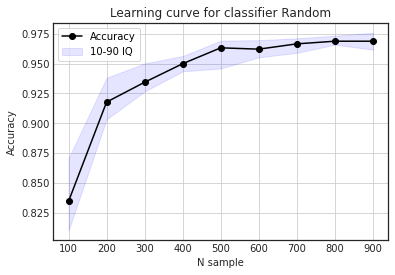

In [ ]:
plot_learning_curve(df,"Random")